In [48]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
# PLOTTING OPTIONS
fig_width_pt = 3*246.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean+0.5     # height in inches
fig_size =  [fig_width,fig_height]

params = { 'axes.labelsize': 22,
          'font.family': 'serif',
          'font.serif': 'Computer Modern Raman',
          'font.size': 24,
          'legend.fontsize': 20,
          'xtick.labelsize': 24,
          'ytick.labelsize': 24,
          'axes.grid' : False,
          'text.usetex': True,
          'savefig.dpi' : 100,
          'lines.markersize' : 14,
          'figure.figsize': fig_size}

mpl.rcParams.update(params)

In [49]:
from pycbc.workflow import WorkflowConfigParser
from pycbc.inference import models,io
from pycbc.inference.io import DynestyFile
import h5py,pycbc
from pycbc.waveform.utils import apply_fd_time_shift
from pycbc.types import TimeSeries

In [50]:
pycbc.init_logging(False)

In [51]:
cp = WorkflowConfigParser(['./inference-2048.ini'])

In [52]:
fp = io.loadfile('GW150914-ringdown220.hdf','r')
data = fp.read_data()
psd = fp.read_psds()

model = models.read_from_config(cp,data=data,psds=psd)

No sampling_params section read from config file


In [53]:
#model = models.read_from_config(cp)

In [54]:
#with DynestyFile('GW150914-ringdown220.hdf','w') as f:
#    f.write_psd(model.psds)
#    f.write_stilde(model.data)
#    f.write_config_file(cp)

In [55]:
#Choose an arbitrary set of parameters, for demonstration purpose
params = {'final_mass':60,
        'final_spin':0.8,
         'amp220':5e-20,
         'phi220':0}
model.update(**params)

In [56]:
_ = model.loglikelihood

In [57]:
model.loglikelihood

-336821.0954033678

In [58]:
model.lognl

-325048.8647137272

In [59]:
model.loglr

-11772.230689640623

In [60]:
print(np.sqrt(2*model.loglr))

nan


/work/yifan.wang/ringdown/GW150914/pycbc_run/subgating-0713-removerindex+1/env/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


In [61]:
model.static_params

{'approximant': 'TdQNMfromFinalMassSpin',
 'harmonics': 'spheroidal',
 'tref': 1126259462.4083147,
 'ra': 1.95,
 'dec': -1.27,
 'toffset': 0.0,
 'lmns': 221.0,
 'polarization': 0.82,
 'inclination': 3.14159265}

# Plot data and waveforms (in Hanford)

In [62]:
data = model.td_data['H1']

In [63]:
h = model.get_waveforms()
ht = h['H1'].to_timeseries()

In [64]:
gate_times = model.get_gate_times()

In [65]:
start,delay = gate_times['H1']

In [66]:
# the ringdown starting time tc is t_gate_end
tc = start + delay 
tc = 1126259462.42323

# counts the index of the nearest data sample on the floor
idx = np.floor(float(tc-ht.start_time)*ht.sample_rate).astype(int)
# the new starting time, hence t_gate_end lands on a specific data sample 
disctc = ht.sample_times[idx]

# shift the waveform
offset = disctc - tc
shifth = apply_fd_time_shift(h['H1'], offset + h['H1'].epoch, copy=True)
shiftht = shifth.to_timeseries()

# shift the data
fdata = data.to_frequencyseries()
newdata = apply_fd_time_shift(fdata, offset + fdata.epoch,copy=True)
newdatat = newdata.to_timeseries()

In [67]:
int ((tc-ht.start_time) / ht.delta_t)

17250

In [68]:
disctc

1126259462.4228516

In [69]:
rindex_time = ht.start_time + idx * ht.delta_t

In [70]:
float(rindex_time)

1126259462.4228516

In [71]:
float(rindex_time) - disctc

0.0

In [72]:
tc

1126259462.42323

In [73]:
offset

-0.0003783702850341797

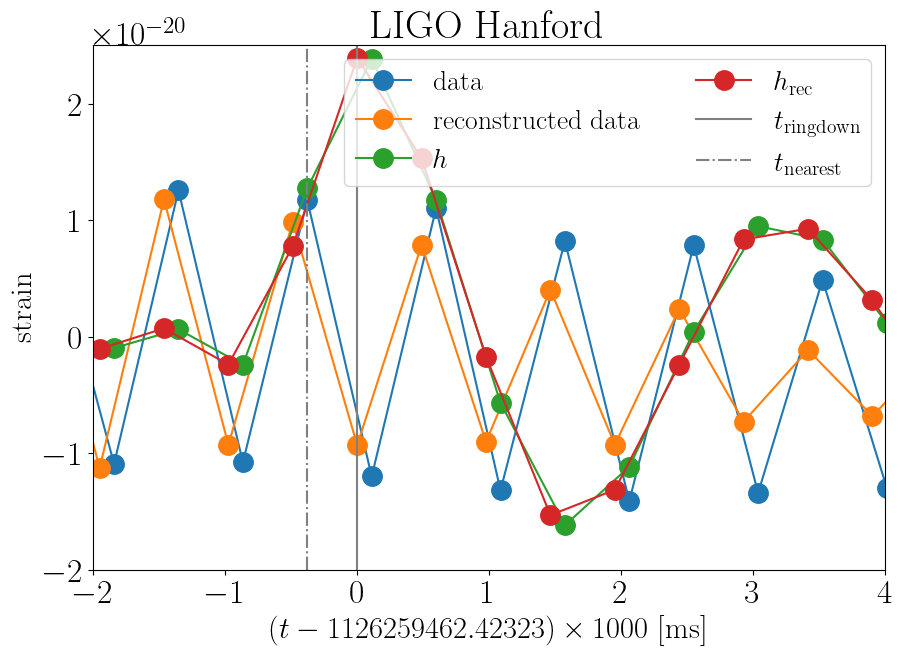

In [74]:
plt.plot( 1000*(data.sample_times - tc), data,'o-',label='data')
plt.plot( 1000*(newdatat.sample_times - tc - offset), newdatat,'o-',label='reconstructed data')

plt.plot( 1000*(ht.sample_times - tc), ht,'o-',label='$h$')
plt.plot( 1000*(shiftht.sample_times - tc - offset),shiftht,'o-',label='$h_\mathrm{rec}$')

plt.axvline(tc - tc,ls='-',color='grey',label='$t_\mathrm{ringdown}$')
plt.axvline((disctc - tc)*1000,ls='-.',color='grey',label='$t_\mathrm{nearest}$')
plt.xlim(-2,4)
plt.ylabel('strain')
plt.ylim(-2e-20,2.5e-20)
plt.xlabel('$(t-'+str(tc)+') \\times 1000 $ [ms]')
plt.legend(ncol=2, loc='best')
plt.title('LIGO Hanford')
plt.savefig('shiftgating.png',bbox_inches='tight')

In [75]:
tc

1126259462.42323

In [76]:
tc = tc +0.00023

In [77]:
tc = 1126259462.42323

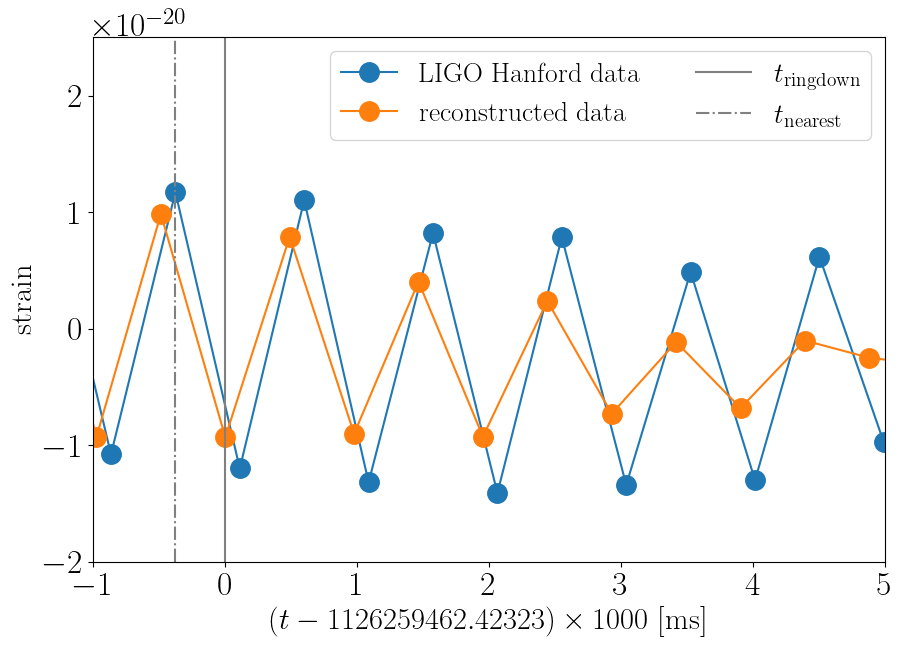

In [78]:
plt.plot( 1000*(data.sample_times - tc), data,'o-',label='LIGO Hanford data')
plt.plot( 1000*(newdatat.sample_times - tc - offset), newdatat,'o-',label='reconstructed data')

plt.axvline(tc - tc,ls='-',color='grey',label='$t_\mathrm{ringdown}$')
plt.axvline((disctc - tc)*1000,ls='-.',color='grey',label='$t_\mathrm{nearest}$')
plt.xlim(-1,5)
plt.ylabel('strain')
plt.ylim(-2e-20,2.5e-20)
plt.xlabel('$(t-'+str(tc)+') \\times 1000 $ [ms]')
plt.legend(ncol=2, loc='best')
#plt.title('LIGO Hanford')
plt.savefig('shiftgating-paper.png',bbox_inches='tight')